In [1]:
import numpy as np
import import_ipynb
#import numpy.linalg as LA
#import LMM as lmm
import random
import time
import os
import pandas as pd
from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
import scanpy as sc
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.patches as mpatches
from statsmodels.graphics.api import abline_plot
import seaborn as sns
import umap
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd

import statsmodels.formula.api as smf
import pandas

np.random.seed(10)

def get_binary_covariate(covariate, covariate_level, data):
    covariate_list = np.zeros((data.obs.shape[0]))
    for i in range(data.obs.shape[0]):
        ### select the ith element of 
        if data.obs[[covariate]].squeeze()[i] == covariate_level:
            covariate_list[i] = 1
    return covariate_list


def get_design_mat(a_metadata_col, data):
    ### given a column of the dat object metadata, return a onehot encoded design matrix
    column_levels = data.obs[a_metadata_col].unique()
    dict_covariate = {}
    for column_level in column_levels:
        print(column_level)
        dict_covariate[column_level] = get_binary_covariate(a_metadata_col, column_level, data)

    #### stack colummns of dict_covariate 
    x = np.column_stack((dict_covariate[column] for column in column_levels))
    return x



def varimax(Phi, gamma = 1.0, q = 100, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    Lambda = dot(Phi, R)

    return {'rotloadings':Lambda, 'rotmat':R}


In [2]:
#### import the immune subpopulation of the rat samples
data = sc.read('/home/delaram/scLMM/sc_mixology/scMix_3cl_merged.h5ad') ## attributes removed
#data = sc.read('/home/delaram/scLMM/sc_mixology/scMix_5cl_merged.h5ad') ## attributes removed


data.var_names_make_unique()
# a.obs['orig.ident'].head()
### renaming the meta info column names: https://github.com/theislab/scvelo/issues/255
data.__dict__['_raw'].__dict__['_var'] = data.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

data_numpy = data.X.toarray()
cell_sums = np.sum(data_numpy,axis=1) # row sums - library size
gene_sums = np.sum(data_numpy,axis=0) # col sums - sum reads in a gene
gene_vars = np.var(data_numpy, axis=0)
data_numpy = data_numpy[:,gene_sums != 0]

### print head pf the data.obs
print(data.obs.head())

#### sample metadata
y_cell_line = data.obs.cell_line_demuxlet
y_sample = data.obs.sample
y_sample = data.obs[['sample']].squeeze()

## working with the rat data
num_cells = data_numpy.shape[0]
num_genes = data_numpy.shape[1]

### print the dimensions of the data - 1401 28335
print(num_cells, num_genes)


num_genes = 5000

#### select num_genes genes based on variance
### calculate the variance for each gene
gene_vars = np.var(data_numpy, axis=0)
### select the top num_genes genes with the highest variance
gene_idx = np.argsort(gene_vars)[::-1][0:num_genes]
### subset the data matrix to the top num_genes genes
data_numpy = data_numpy[:, gene_idx]

#### randomly select num_genes genes
#gene_idx = random.sample(range(0, data_numpy.shape[1]), num_genes)
#data_numpy = data_numpy[:, gene_idx]

y = data_numpy

print(y_sample.unique())
print(y_cell_line.unique())



                   orig.ident  nCount_originalexp  nFeature_originalexp  \
sc_10X_CELL_000001       CELL            266379.0                 10770   
sc_10X_CELL_000002       CELL            248501.0                 11155   
sc_10X_CELL_000003       CELL            250649.0                 10682   
sc_10X_CELL_000004       CELL            249556.0                 10785   
sc_10X_CELL_000005       CELL            243926.0                 10435   

                    unaligned  aligned_unmapped  mapped_to_exon  \
sc_10X_CELL_000001     167234              8341          526950   
sc_10X_CELL_000002     171821             10047          513676   
sc_10X_CELL_000003     174510              8608          513021   
sc_10X_CELL_000004     158346              7796          504676   
sc_10X_CELL_000005     159070              6968          486645   

                    mapped_to_intron  ambiguous_mapping  mapped_to_ERCC  \
sc_10X_CELL_000001             40991              21392               0

In [15]:
#### adding a column to data object for protocol
## empty numpy array in length of the number of cells
y_protocol = np.empty((y.shape[0]), dtype="S10")

for i in range(y.shape[0]):
    if data.obs['sample'][i] in ['sc_10x', 'sc_10X']:
        y_protocol[i] = 'sc_10X'

    elif data.obs['sample'][i] == 'Dropseq':
        y_protocol[i] = 'Dropseq'
        
    else:
        y_protocol[i] = 'CELseq2'

print(y_protocol)
print(len(y_protocol))
data.obs['protocol'] = y_protocol
y_protocol = pd.Series(y_protocol)

[b'sc_10X' b'sc_10X' b'sc_10X' ... b'Dropseq' b'Dropseq' b'Dropseq']
1401


In [4]:
y_protocol.unique()

array([b'sc_10X', b'CELseq2', b'Dropseq'], dtype='|S10')

In [17]:
#### Design matrix : Intercept + Depth + protocol

#x_batch = get_design_mat('batch', data)
x_protocol = get_design_mat('protocol', data)
#x_cell_line = get_design_mat('cell_line', data)
#x = np.column_stack((data.obs.nCount_originalexp, x_protocol)) #, x_batch
#x = sm.add_constant(x) ## adding the intercept

x = np.column_stack((np.ones(y.shape[0]), np.array(data.obs.nCount_originalexp)))
print(x[0:3,:])
print(x.shape)

b'sc_10X'
b'CELseq2'
b'Dropseq'
[[1.00000e+00 2.66379e+05]
 [1.00000e+00 2.48501e+05]
 [1.00000e+00 2.50649e+05]]
(1401, 2)


/home/delaram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [18]:
### fit a poisson regression model to each gene and save the results

num_vars = x.shape[1]

### make an empty array to store the p-values and coefficients
pvalue = []
coefficient = []
yhat = []
tvalues = []
resid_pearson = []
resid_deviance = []
resid_response = []
resid_working = []
fittedvalues = []
nobs = []
models = []

pearson_chi2 = []
deviance = []
null_deviance = []

### time the fitting process
start_time = time.time()

for i in range(len(y[0])):
    y_a_gene = y[:, i]
    model = sm.GLM(y_a_gene, x, family=sm.families.Poisson())
    result = model.fit()
    #print(result.summary())
    
    models.append([result])
    coefficient.append([result.params])
    pvalue.append([result.pvalues]) ## yhat == fittedvalue == mu
    yhat.append([result.predict()])
    fittedvalues.append([result.fittedvalues])

    nobs.append([result.nobs])
    tvalues.append([result.tvalues])
    resid_pearson.append([result.resid_pearson])
    resid_deviance.append([result.resid_deviance])
    resid_response.append([result.resid_response])
    #resid_working.append([result.resid_working])
    
    pearson_chi2.append([result.pearson_chi2])
    deviance.append([result.deviance])
    null_deviance.append([result.null_deviance])

end_time = time.time()
print('time to fit the model: ', end_time - start_time)


time to fit the model:  23.19840407371521


In [19]:

pvalue = np.asarray(pvalue).reshape(num_genes, num_vars)
coefficient = np.asarray(coefficient).reshape(num_genes, num_vars)
tvalues = np.asarray(tvalues).reshape(num_genes, num_vars)
#### print the head of the pvalues
print(pvalue[0:5, :])

yhat = np.asarray(yhat).reshape(num_genes, num_cells)
fittedvalues = np.asarray(fittedvalues).reshape(num_genes, num_cells)
resid_pearson = np.asarray(resid_pearson).reshape(num_genes, num_cells)
resid_deviance = np.asarray(resid_deviance).reshape(num_genes, num_cells)
resid_response = np.asarray(resid_response).reshape(num_genes, num_cells)
#resid_working = np.asarray(resid_working).reshape(num_genes, num_cells)
nobs = np.asarray(nobs).reshape(num_genes, 1)

pearson_chi2 = np.asarray(pearson_chi2).reshape(num_genes, 1)
deviance = np.asarray(deviance).reshape(num_genes, 1)
null_deviance = np.asarray(null_deviance).reshape(num_genes, 1)


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [20]:
#### chosing a random gene to plot
i = 800 ## gene index
result = models[i][0] 
fittedvalues_i = fittedvalues[i]
y_i = y[:, i]


### get the summary of the model
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1401
Model:                            GLM   Df Residuals:                     1399
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6079.8
Date:                Tue, 04 Apr 2023   Deviance:                       7228.8
Time:                        15:57:39   Pearson chi2:                 7.17e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8573      0.019     45.503      0.0

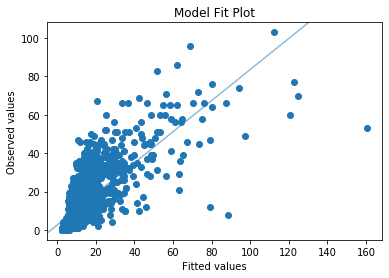

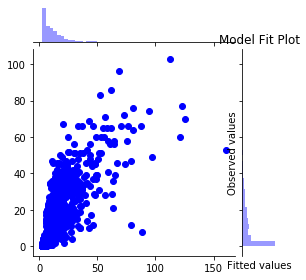

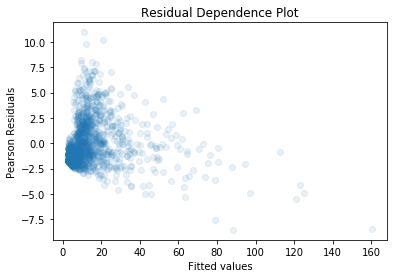

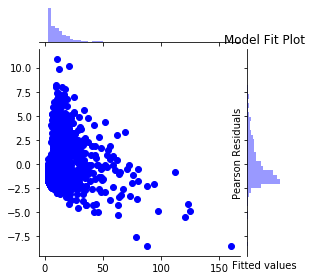

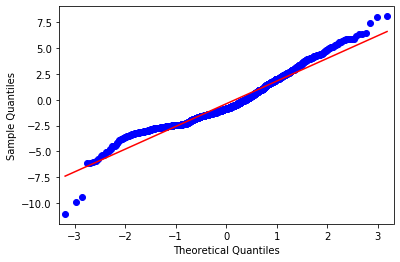

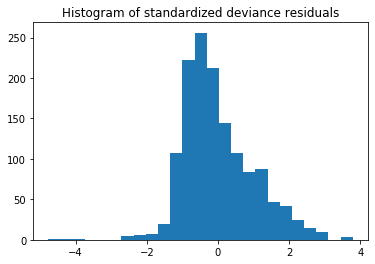

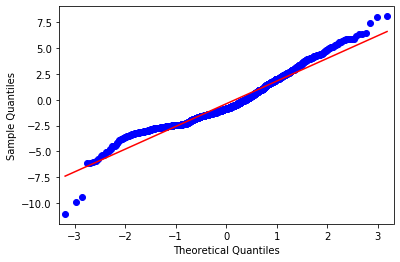

In [21]:
### diagnostic plots of the model outputs
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots()
ax.scatter(fittedvalues_i, y[:, i])
line_fit = sm.OLS(y_i, sm.add_constant(fittedvalues_i, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax, alpha=0.5)

ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values')

sns.jointplot(fittedvalues_i, y[:, i], kind='scatter', stat_func=None, color='b', height=4)
sns.set_context(font_scale=0.9)                                                  
plt.title('Model Fit Plot')
plt.xlabel('Fitted values')
plt.ylabel('Observed values')
## change the size of the text in plot
plt.rc('font', size=10)

fig, ax = plt.subplots()
resid_pearson_i = resid_pearson[i]
ax.scatter(fittedvalues_i, resid_pearson_i, alpha=0.1)
#ax.hlines(0, 0, 7)
#ax.set_xlim(0, 7)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

sns.jointplot(fittedvalues_i, resid_pearson_i, kind='scatter', stat_func=None, color='b', height=4)
sns.set_context(font_scale=0.9)                                                  
plt.title('Model Fit Plot')
plt.xlabel('Fitted values')
plt.ylabel('Pearson Residuals')
## change the size of the text in plot
plt.rc('font', size=10)
plt.show()

from scipy import stats
fig, ax = plt.subplots()
resid = resid_deviance[i]
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals')

from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')

In [34]:
#### calculate the goodness of fit of GLM model
# https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLMResults.html#statsmodels.genmod.generalized_linear_model.GLMResults

### statsmodels GLM source code:
# https://github.com/statsmodels/statsmodels/blob/main/statsmodels/genmod/families/links.py

### poisson family link function
# https://github.com/statsmodels/statsmodels/blob/main/statsmodels/genmod/families/family.py


print('log-likelihood of the model: ', result.llf)

### calculate the null deviance manually - float
# NullDeviance = 2*(LL(SaturatedModel)−LL(NullModel))
# The value of the deviance function for the model fit with a constant as the only regressor
# GLMResults.llf: Value of the loglikelihood function evalued at params. See statsmodels.families.family for distribution-specific loglikelihoods.
null_deivance_i = 2*(result.llnull - result.llf)
print('null deviance manual calculation: ', null_deivance_i) ## why the result is different from the result.null_deviance?
print('null deviance: ',result.null_deviance)


### calculate the deviance - float
# The value of the deviance function for the model fit with the full set of regressors
# ResidualDeviance = 2*(LL(SaturatedModel)−LL(ProposedModel))
deviance_i =result.deviance 
print('deviance: ', deviance_i)


### Response residual - array
# The response residuals are defined as endog - fittedvalues
response_residual_i = y_i - fittedvalues_i
print('response residual manual: ', response_residual_i[:3])
print('response residual is: ', resid_response[i][:3])

### Deviance residual - how is this calculated? - array
print('residual deviance is: ', resid_deviance[i][1:3])


### The Pearson residuals - response residuals scaled by the square root of the variance function
# (endog - mu)/sqrt(VAR(mu)) where VAR is the distribution specific variance function
resid_pearson_i = (y_i - result.mu)/np.sqrt(result.family.variance(result.mu)) ## variance function of the poisson family is power?
print('pearson residual manual: ', resid_pearson_i[:3])
print('pearson residual is: ', resid_pearson[i][:3])


### calculate the Pearson’s Chi-Squared statistic 
# the sum of the squares of the Pearson residuals.
Pearson_Chi_Squared_i = sum(resid_pearson[i]**2)
print('Pearson_Chi_Squared manual: ', Pearson_Chi_Squared_i)
print('Pearson_Chi_Squared: ', result.pearson_chi2)


### calculate the BIC - float
# BIC : deviance - df_resid * log(nobs)
BIC_i = deviance_i - result.df_resid * np.log(nobs[0])
print('BIC manual: ', BIC_i)
print('BIC is: ', result.bic)


### calculate the AIC - float
# AIC: aike Information Criterion
# -2 * llf + 2 * (df_model + 1)
## df_model: rank of the regression matrix excluding the intercept:  df_model = k_exog - 1 = 0 is only strain is included
AIC_i = deviance_i + 2 * (result.df_model + 1)
AIC_i = -2 * result.llf + 2 * (result.df_model + 1)
print('AIC manual: ', AIC_i)
print('AIC is: ', result.aic)


### calculate the pseudo R-squared - float
pseudo_rsquared_i = 1 - abs(result.deviance/result.null_deviance)
print('pseudo R-squared manual: ', pseudo_rsquared_i)
#print('pseudo R-squared is: ', result.pseudo_rsquared)

### calculate the Wald test - float
# result.wald_test('x1 = x2 = 0')

# GLMResults.wald_test : Compute a Wald-test for a joint linear hypothesis.
# GLMResults.compare_lr_test : Likelihood ratio test for comparing two models.\n"

print(resid_response.T.shape)
print(y.shape)

log-likelihood of the model:  -2403.9149797161613
null deviance manual calculation:  -1647.540141207116
null deviance:  3736.23824131236
deviance:  2088.6981001052427
response residual manual:  [-107.38410127  -60.82307844  -55.00558931]
response residual is:  [-10.56872579  -8.64850564  -8.07187155]
residual deviance is:  [-2.56633299 -2.3252661 ]
pearson residual manual:  [ 7.99028083 11.84936127 14.1485264 ]
pearson residual is:  [-2.45262742 -2.25966683 -2.07917311]
Pearson_Chi_Squared manual:  1950.7187345758864
Pearson_Chi_Squared:  1950.7187345758866
BIC manual:  [-8046.97512322]
BIC is:  -8046.975123220229
AIC manual:  4811.8299594323225
AIC is:  4811.8299594323225
pseudo R-squared manual:  0.4409622820595124
(1401, 5000)
(1401, 5000)


In [23]:
###### plots for the 3cl data

def plot_pca(pca_scores, pca, num_components_to_plot, title='PCA of the data matrix'):
    
    for i in range(1, num_components_to_plot):
        ## color PCA based on strain
        plt.figure()
        plt.scatter(pca_scores[:,0], pca_scores[:,i], c=cell_line_color, s=1) 
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.title(title)
        plt.legend(handles=[mpatches.Patch(color='springgreen', label='HCC827'),
                        mpatches.Patch(color='red', label='H1975'),
                        mpatches.Patch(color='orchid', label='H2228')])
        plt.show()


        ###  ## color PCA based on sample
        plt.figure()
        plt.scatter(pca_scores[:,0], pca_scores[:,i], c=protocol_color, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.legend(handles=[mpatches.Patch(color='palegreen', label='sc_10X'),
            mpatches.Patch(color='yellow', label='CELseq2'),
            mpatches.Patch(color='pink', label='Dropseq')], loc='best')
        plt.show()


    # plot the variance explained by each PC
    plt.figure()
    plt.plot(pca.explained_variance_ratio_)
    plt.title('Variance explained by each PC')
    plt.xlabel('PC')
    plt.ylabel('Variance explained')
    plt.show()


def plot_umap(pca_scores, pca , title='UMAP of the PC components of the gene expression matrix'):

    ### apply UMAP to teh PCA components
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(pca_scores)
    print('embedding shape: ', embedding.shape)
    
    ### plot the UMAP embedding
    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=cell_line_color, s=1)
    plt.title(title)
    plt.legend(handles=[mpatches.Patch(color='springgreen', label='HCC827'),
                        mpatches.Patch(color='red', label='H1975'),
                        mpatches.Patch(color='orchid', label='H2228')])
    
    plt.show()

    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=protocol_color, s=1)
    plt.title(title)
    plt.legend(handles=[mpatches.Patch(color='palegreen', label='sc_10X'),
            mpatches.Patch(color='yellow', label='CELseq2'),
            mpatches.Patch(color='pink', label='Dropseq')], loc='best')
    plt.show()




### print the levels of the protocol metadata ['sc_10X' 'CELseq2' 'Dropseq']
# print the levels of the cell line metadata ['HCC827' 'H1975' 'H2228']

### generating the list of colors for samples
my_color = {b'sc_10X': 'palegreen', b'CELseq2':'yellow', b'Dropseq':'pink'}
### generate a list containing the corresponding color for each sample
protocol_color = [my_color[y_protocol[i]] for i in range(len(y_protocol))]

my_color = {'HCC827': 'springgreen', 'H1975':'red', 'H2228':'orchid'}
cell_line_color = [my_color[y_cell_line[i]] for i in range(len(y_cell_line))]

### applying PCA to the data matrix
num_components = 30


In [42]:
### print the unique values of protocol_color list
print(np.unique(protocol_color))


['palegreen' 'pink' 'yellow']


In [10]:
###### plots for the 5cl data

def plot_pca(pca_scores, pca, num_components_to_plot, title='PCA of the data matrix'):
    
    for i in range(1, num_components_to_plot):
        ## color PCA based on strain
        plt.figure()
        plt.scatter(pca_scores[:,0], pca_scores[:,i], c=cell_line_color, s=1) 
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.title(title)
        plt.legend(handles=[mpatches.Patch(color='springgreen', label='HCC827'),
                        mpatches.Patch(color='red', label='H838'),
                        mpatches.Patch(color='orchid', label='H1975'),
                        mpatches.Patch(color='blue', label='H2228'),
                        mpatches.Patch(color='orange', label='A549')])
        
        
        plt.show()


        ###  ## color PCA based on sample
        plt.figure()
        plt.scatter(pca_scores[:,0], pca_scores[:,i], c=sample_color, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.legend(handles=[mpatches.Patch(color='palegreen', label='sc_10x'),
            mpatches.Patch(color='yellow', label='CELseq2_p1'),
            mpatches.Patch(color='pink', label='CELseq2_p2'),
            mpatches.Patch(color='orange', label='CELseq2_p3')], loc='best')        
        plt.show()




        ## color PCA based on protocol
        plt.figure()
        plt.scatter(pca_scores[:,0], pca_scores[:,i], c=protocol_color, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.legend(handles=[mpatches.Patch(color='green', label=b'sc_10x'),
            mpatches.Patch(color='orchid', label=b'CELseq2')], loc='best')      
        plt.show()
        


    # plot the variance explained by each PC
    plt.figure()
    plt.plot(pca.explained_variance_ratio_)
    plt.title('Variance explained by each PC')
    plt.xlabel('PC')
    plt.ylabel('Variance explained')
    plt.show()


    


def plot_umap(pca_scores, pca , title='UMAP of the PC components of the gene expression matrix'):

    ### apply UMAP to teh PCA components
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(pca_scores)
    print('embedding shape: ', embedding.shape)
    
    ### plot the UMAP embedding
    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=cell_line_color, s=1)
    plt.title(title)
    plt.legend(handles=[mpatches.Patch(color='springgreen', label='HCC827'),
                        mpatches.Patch(color='red', label='H838'),
                        mpatches.Patch(color='orchid', label='H1975'),
                        mpatches.Patch(color='blue', label='H2228'),
                        mpatches.Patch(color='orange', label='A549')])

    plt.show()

    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=sample_color, s=1)
    plt.title(title)
    plt.legend(handles=[mpatches.Patch(color='palegreen', label='sc_10x'),
            mpatches.Patch(color='yellow', label='CELseq2_p1'),
            mpatches.Patch(color='pink', label='CELseq2_p2'),
            mpatches.Patch(color='orange', label='CELseq2_p3')], loc='best')
    plt.show()



    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=protocol_color, s=1)
    plt.title(title)
    plt.legend(handles=[mpatches.Patch(color='green', label=b'sc_10x'),
            mpatches.Patch(color='orchid', label=b'CELseq2')], loc='best')      
    plt.show()


### generating the list of colors for samples
my_color = {'sc_10x': 'palegreen', 'CELseq2_p1':'yellow', 'CELseq2_p2':'pink', 'CELseq2_p3':'orange'}
### generate a list containing the corresponding color for each sample
sample_color = [my_color[y_sample[i]] for i in range(len(y_sample))]

my_color = {b'sc_10x': 'green', b'CELseq2':'orchid'}
### generate a list containing the corresponding color for each sample
protocol_color = [my_color[y_protocol[i]] for i in range(len(y_protocol))]

my_color = {'HCC827': 'springgreen', 'H838':'red', 'H1975':'orchid', 'H2228':'blue', 'A549':'orange', 'NA':'black'}
cell_line_color = [my_color[y_cell_line[i]] for i in range(len(y_cell_line))]


### applying PCA to the data matrix
num_components = 30


In [ ]:
### using pipeline to scale the data first
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
pca_scores = pipeline.fit_transform(y)
pca = pipeline.named_steps['pca']
pca_loading = pca.components_

plot_pca(pca_scores, pca, 8, title='PCA of data')
plot_umap(pca_scores, pca, title='UMAP of the PC components of the data')

In [17]:
#print column names of data.obs
print(data.obs.columns)

Index(['orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'unaligned',
       'aligned_unmapped', 'mapped_to_exon', 'mapped_to_intron',
       'ambiguous_mapping', 'mapped_to_ERCC', 'mapped_to_MT',
       'number_of_genes', 'total_count_per_cell', 'non_mt_percent',
       'non_ribo_percent', 'outliers', 'is_cell_control',
       'total_features_by_counts', 'log10_total_features_by_counts',
       'total_counts', 'log10_total_counts', 'pct_counts_in_top_50_features',
       'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features',
       'pct_counts_in_top_500_features', 'total_features',
       'log10_total_features', 'pct_counts_top_50_features',
       'pct_counts_top_100_features', 'pct_counts_top_200_features',
       'pct_counts_top_500_features', 'cell_line', 'cell_line_demuxlet',
       'demuxlet_cls', 'sizeFactor', 'sample', 'non_ERCC_percent', 'batch',
       'cell_number', 'protocol'],
      dtype='object')


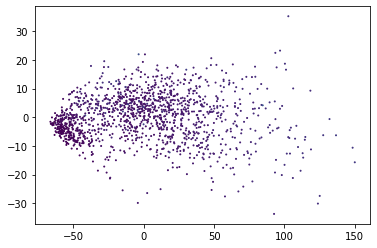

In [44]:
embedding = pca_scores
i = 5
plt.figure()
plt.scatter(embedding[:, 0], embedding[:, i], c=data.obs['unaligned'], s=1)
plt.show()

In [ ]:
##### First implementation of Varimax rotation ####
## method: scale(original pc scores) %*% rotmat

## apply varimax rotation to the loadings
varimax_rot = varimax(pca_loading.T)
loadings_rot = varimax_rot['rotloadings']
rotmat = varimax_rot['rotmat']
pca_scores_rot = dot(pca_scores, rotmat)


print('loadings_rot shape: ', loadings_rot.shape)
print('rotmat shape: ', rotmat.shape)
print('pca_scores shape: ', pca_scores.shape)
print('pca_scores_rot shape: ', pca_scores_rot.shape)


plot_pca(pca_scores_rot, pca,7, title='PCA of varimax rotated pearson residuals')
plot_umap(pca_scores_rot, pca, title='UMAP of the varimax-PCs on pearson residuals')



In [ ]:
### applying PCA to the pearson residuals

pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
pca_scores = pipeline.fit_transform(resid_pearson.T)
pca = pipeline.named_steps['pca']
pca_loading = pca.components_

#print('explained variance ratio: ', pca.explained_variance_ratio_)
#print('singular values: ', pca.singular_values_)#
print('noise_variance: ', pca.noise_variance_)

plot_pca(pca_scores, pca, 8, title='PCA of pearson residuals')
plot_umap(pca_scores, pca, title='UMAP of the PC components of the pearson residuals')


In [ ]:
### applying PCA to the deviance residuals
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
pipeline.fit_transform(resid_deviance)
pca = pipeline.named_steps['pca']

#pca = PCA(n_components=20)
#pca.fit(resid_response)

#print('explained variance ratio: ', pca.explained_variance_ratio_)
#print('singular values: ', pca.singular_values_)#
print('noise_variance: ', pca.noise_variance_)

plot_pca(pca_scores, pca, 5, title='PCA of deviance residuals')
plot_umap(pca_scores, pca, title='UMAP of the PC components of the deviance residuals')

In [14]:

print(y_sample.unique())
print(y_cell_line.unique())
a_binary_cov = get_binary_covariate('cell_line', 'A549', data)


print('pca_scores shape: ', pca_scores_rot.shape)
print(a_binary_cov.shape)


['sc_10x' 'CELseq2_p1' 'CELseq2_p2' 'CELseq2_p3']
['HCC827' 'H838' 'H1975' 'H2228' 'A549']
pca_scores shape:  (4827, 30)
(4827,)


In [17]:
# decision tree for feature importance on a classification problem

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
#X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)



In [18]:
### matching pca factors to different covariates in the data

def get_importance_df(factor_scores, a_binary_cov):

    models = {'LogisticRegression': LogisticRegression(), 
              'DecisionTree': DecisionTreeClassifier(), 'RandomForest': RandomForestClassifier(), 
              'XGB': XGBClassifier(), 'KNeighbors_permute': KNeighborsClassifier()}

    importance_dict = {}
    for model_name, model in models.items():
        X, y = factor_scores, a_binary_cov
        model.fit(X, y)

        if model_name == 'LogisticRegression':
            importance_dict[model_name] = model.coef_[0]

        elif model_name in ['DecisionTree', 'RandomForest', 'XGB']:
            # get importance
            importance_dict[model_name] = model.feature_importances_
        else:
            # perform permutation importance
            results = permutation_importance(model, X, y, scoring='accuracy')
            # perform permutation importance
            importance_dict[model_name] = results.importances_mean

    importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['PC'+str(i) for i in range(1, num_components+1)])
    return importance_df


covariate_name =  'sample'#'cell_line'
factor_scores = pca_scores_rot
cov_level_feature_df_dict = {}

y_label = data.obs[covariate_name]

for covariate_level in y_label.unique():
    a_binary_cov = get_binary_covariate(covariate_name, covariate_level, data)
    factor_scores = pca_scores_rot
    cov_level_feature_df_dict[covariate_level] = get_importance_df(factor_scores, a_binary_cov)



/home/delaram/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:31:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/delaram/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/delaram/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarnin

[10:32:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/delaram/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/delaram/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarnin

[10:33:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/delaram/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/delaram/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarnin

[10:35:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [93]:
y_label.unique()

array(['sc_10x', 'CELseq2_p1', 'CELseq2_p2', 'CELseq2_p3'], dtype=object)

In [94]:
### visualizing the feature importance using a heatmap
import seaborn as sns
import pandas as pd
import dataframe_image as dfi


a_cov_match_factor_dict = {}
a_cov_match_factor_dict_all = {}

for covariate_level in cov_level_feature_df_dict:
    importance_df = cov_level_feature_df_dict[covariate_level]
    dfi.export(importance_df.style.background_gradient(cmap='Blues', axis=1 ), '/home/delaram/scLMM/feature_heatmap_images/imp_heatmap_'+ covariate_level+'.png')
    
    ## identify the column (PC) with max value in each row (ML model)
    match_factor_table = importance_df.idxmax(axis='columns')
    highest_vote_factor = str(list(match_factor_table.mode())[0])
    #print('Highest scoring factor in each model for \"'+ covariate_level+ '\":\n', match_factor_table.to_frame(name=''), '\n')
    
    print('Highest factor for \"'+ covariate_level+ '\" based on voting: ', highest_vote_factor)

    a_cov_match_factor_dict[covariate_level] = highest_vote_factor
    a_cov_match_factor_dict_all[covariate_level] = match_factor_table.to_frame(name='')



Highest factor for "sc_10x" based on voting:  PC21
Highest factor for "CELseq2_p1" based on voting:  PC8
Highest factor for "CELseq2_p2" based on voting:  PC8
Highest factor for "CELseq2_p3" based on voting:  PC12


In [21]:
covariate_level = list(cov_level_feature_df_dict.keys())[2]
print(covariate_level)
importance_df = cov_level_feature_df_dict[covariate_level]
importance_df.style.background_gradient(cmap='Blues', axis=1 )

CELseq2_p2


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
LogisticRegression,0.081706,-0.092543,0.024025,-0.054930,-0.237324,0.040273,-0.104160,0.033172,-0.018263,0.031643,-0.020018,-0.031550,-0.023525,0.030870,0.081036,-0.077395,-0.247046,-0.155100,0.002066,-0.081292,-0.062363,-0.060623,0.059658,2.431515,-0.055700,0.049511,0.043741,0.106605,0.050695,0.192993
DecisionTree,0.000000,0.000000,0.000000,0.002319,0.000000,0.000000,0.002609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004504,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.982932,0.000000,0.000858,0.003445,0.000000,0.000000,0.003334
RandomForest,0.010502,0.003263,0.016963,0.004009,0.027723,0.024488,0.018979,0.017231,0.005124,0.017176,0.017693,0.038237,0.009227,0.004488,0.024827,0.004245,0.027142,0.010956,0.023717,0.008483,0.004008,0.058718,0.007845,0.566366,0.006140,0.005952,0.004007,0.005229,0.020822,0.006439
XGB,0.012508,0.028232,0.000000,0.031964,0.000000,0.000000,0.000000,0.002921,0.003835,0.000000,0.000000,0.004595,0.000000,0.031825,0.000000,0.000000,0.023551,0.000000,0.000000,0.036027,0.000480,0.000000,0.000000,0.817082,0.000000,0.004274,0.000000,0.000000,0.000000,0.002706
KNeighbors_permute,0.017734,-0.000994,-0.000539,-0.000580,-0.000414,-0.000663,0.005013,0.009654,-0.001243,-0.000953,-0.000663,0.004143,-0.000829,-0.000331,0.000373,-0.000331,0.007914,-0.000953,-0.000746,0.000000,-0.000787,0.018645,0.000000,0.045328,-0.000041,-0.001119,-0.000787,-0.000373,0.032981,0.000000


12

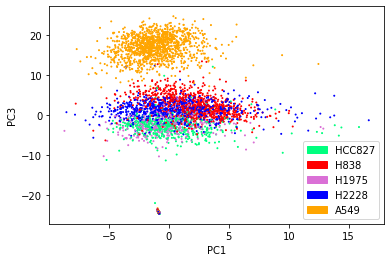

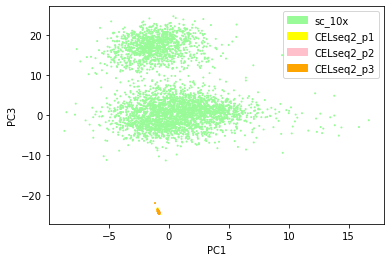

In [59]:
for covariate_level in a_cov_match_factor_dict:
        print(covariate_level, a_cov_match_factor_dict[covariate_level])
        
        highest_vote_factor = a_cov_match_factor_dict[covariate_level]
        i = int(highest_vote_factor[2:]) - 1
        plt.figure()
        plt.scatter(pca_scores_rot[:,0], pca_scores_rot[:,i], c=cell_line_color, s=1) 
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.legend(handles=[mpatches.Patch(color='springgreen', label='HCC827'),
                        mpatches.Patch(color='red', label='H838'),
                        mpatches.Patch(color='orchid', label='H1975'),
                        mpatches.Patch(color='blue', label='H2228'),
                        mpatches.Patch(color='orange', label='A549')])


        #plt.show()
        plt.savefig('/home/delaram/scLMM/feature_heatmap_images/PCAplot_match_'+ covariate_level+'_c_cell_line.png')


        plt.figure()
        plt.scatter(pca_scores_rot[:,0], pca_scores_rot[:,i], c=sample_color, s=1)
        plt.xlabel('PC1')
        plt.ylabel('PC'+str(i+1))
        plt.legend(handles=[mpatches.Patch(color='palegreen', label='sc_10x'),
                mpatches.Patch(color='yellow', label='CELseq2_p1'),
                mpatches.Patch(color='pink', label='CELseq2_p2'),
                mpatches.Patch(color='orange', label='CELseq2_p3')], loc='best')
        #plt.show()
        plt.savefig('/home/delaram/scLMM/feature_heatmap_images/PCAplot_match_'+ covariate_level+'_c_sample.png')
